# Santander Customer Satisfaction

https://www.kaggle.com/c/santander-customer-satisfaction/overview

From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

In this competition, you'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

### Setup

In [2]:
import os
os.getcwd()

'/Users/joshdidcote/Dev/kaggle-competitions/Santander-customer-satisfaction'

In [21]:
from typing import List
from pathlib import Path
import os

FILE_PATH = Path("Santander-customer-satisfaction")
is_correct_dir = Path(os.getcwd()).name == str(FILE_PATH)
if is_correct_dir:
    os.chdir("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc = {'figure.figsize':(10, 6)})
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

from mlutils.preprocess.missing import check_missingness
from mlutils.preprocess.pipeline import extract_x_y, preprocessing_pipeline
from mlutils.visualise.features import plot_importances

In [30]:
pipeline = {}

# Load data
train = pd.read_csv(FILE_PATH / "Data/train.csv").drop("ID", axis=1)
test = pd.read_csv(FILE_PATH / "Data/test.csv").drop("ID", axis=1)

**No missing data**

In [3]:
check_missingness(train)

,pct_missing


Whilst analysing column variances, I spotted var3 has a lot of values with a value of -999999.00. 

Var3 was one of the most predictive feature from previous analysis - strategy will be to impute this using median for now and add a flag to show the value has been imputed.

**Approximately 15% of these values are missing**

In [4]:
train["var3"].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [5]:
def impute_var3(df: pd.DataFrame) -> pd.DataFrame:
    df.loc[df["var3"] == -999999, "var3"] = np.nan
    imputer = SimpleImputer(strategy="median")
    df["var3_imputed"] = np.where(df["var3"].isna(), 1, 0)
    df[["var3"]] = imputer.fit_transform(df[["var3"]])
    return df

pipeline["impute_var3"] = (impute_var3, None)

### EDA


This data set is highly dimensional (370 features).

In [6]:
train.shape

(76020, 370)

**Look at distribution of feature variances, mean and median**

In [7]:
def get_col_summary(df: pd.DataFrame) -> pd.DataFrame:

    # Min max scale so variances are comparable
    df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

    summary_fns = {
    "variance": np.var,
    "mean": np.mean,
    "median": np.median
    }

    _ = []
    for name, fn in summary_fns.items():
        _.append(df.apply(fn).to_frame(name=name))

    summary_df = pd.concat(_, axis=1)

    # Ignore var3 as this has already been analysed/dealt with 
    summary_df = summary_df[~summary_df.index.isin(["var3"])]

    return summary_df

col_summary = get_col_summary(train)
col_summary.head()

,variance,mean,median
var15,0.016787,0.282129,0.23
imp_ent_var16_ult1,0.000059,0.000411,0.00
imp_op_var39_comer_ult1,0.000693,0.005615,0.00
imp_op_var39_comer_ult3,0.000675,0.005685,0.00
imp_op_var40_comer_ult1,0.000128,0.000432,0.00


**First look at distribution of variance for each column**

<AxesSubplot:xlabel='variance', ylabel='Count'>

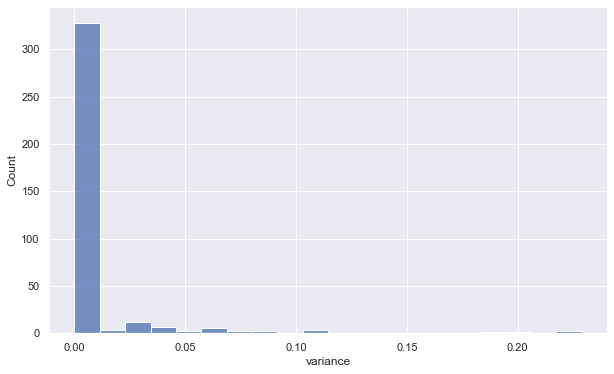

In [8]:
sns.histplot(col_summary["variance"], bins=20)

There is a significant number of columns with 0 or near zero variance.
1. Remove any columns with exactly 0 variance as these will add no value
1. Investigate very low variance columns, and whether they are predictive of the target

In [9]:
def get_zero_var_cols(df: pd.DataFrame) -> List[str]:
    """Get columns with zero variance

    Args:
        df (pd.DataFrame): Output from get_col_summary

    Returns:
        pd.DataFrame: _description_
    """
    return list(df[df["variance"] == 0].index.values)


In [10]:
# How many features have zero variance?
zero_var_cols = get_zero_var_cols(col_summary)
print(f"There are {len(zero_var_cols)} ({np.round(len(zero_var_cols) / len(train.columns) * 100, 2)}%) columns with 0 variance. ")

There are 34 (9.19%) columns with 0 variance. 


**Look at low variance columns and look at correlation with target**

In [11]:
col_summary_pos_var = col_summary[~col_summary.index.isin(zero_var_cols)]

In [12]:
def get_target_correlations(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate correlation between each variable and the target
    """
    target_corrs = {}
    for col in [x for x in df.columns if x != "TARGET"]:
        _ = df[[col, "TARGET"]].corr()
        target_corrs[col] = _.loc[_.index == col, "TARGET"].values
    target_corr_df = pd.melt(pd.DataFrame(target_corrs), value_name="correlation", var_name="col")
    target_corr_df.set_index("col", inplace=True)
    target_corr_df.index.name = None
    return target_corr_df

In [13]:
col_summary_pos_var = pd.merge(
    col_summary_pos_var,
    get_target_correlations(train),
    left_index=True,
    right_index=True,
    how="left"
)

In [14]:
col_summary_pos_var

,variance,mean,median,correlation
var15,0.016787,0.282129,0.230000,0.101322
imp_ent_var16_ult1,0.000059,0.000411,0.000000,-0.000017
imp_op_var39_comer_ult1,0.000693,0.005615,0.000000,0.010353
imp_op_var39_comer_ult3,0.000675,0.005685,0.000000,0.003517
imp_op_var40_comer_ult1,0.000128,0.000432,0.000000,0.003119
...,...,...,...,...
saldo_medio_var44_hace3,0.000036,0.000075,0.000000,-0.002553
saldo_medio_var44_ult1,0.000035,0.000112,0.000000,-0.003104
saldo_medio_var44_ult3,0.000051,0.000142,0.000000,-0.003015
var38,0.000069,0.005087,0.004596,-0.019510


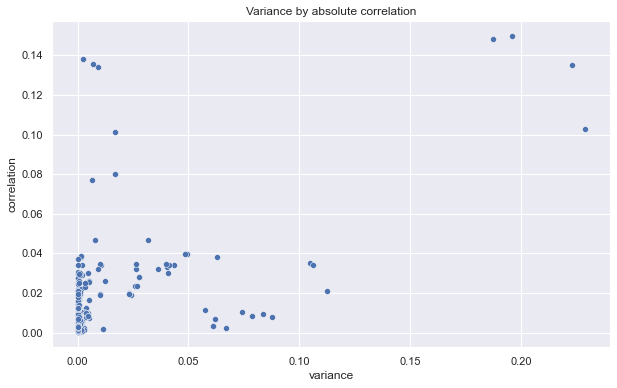

In [15]:
ax = sns.scatterplot(x=col_summary_pos_var["variance"], y=np.abs(col_summary_pos_var["correlation"]))
ax.set_title("Variance by absolute correlation")
plt.show()

From the above plot it looks like there are a number of columns with very low variance by relatively high target correlation.

Take a closer look at the low correlation/variance cols and see if we can remove these.

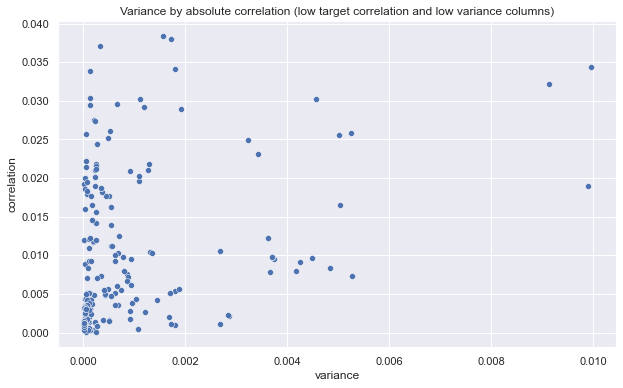

In [16]:
col_var_cutoff = 0.01
col_corr_cutoff = 0.04

low_var_low_corr = col_summary_pos_var.copy()
low_var_low_corr = low_var_low_corr.loc[(np.abs(low_var_low_corr.correlation) <= col_corr_cutoff) & (low_var_low_corr.variance <= col_var_cutoff)]


ax = sns.scatterplot(x=low_var_low_corr["variance"], y=np.abs(low_var_low_corr["correlation"]))
ax.set_title("Variance by absolute correlation (low target correlation and low variance columns)")
plt.show()

**Can we build a model using these features that beats a random model**

In [17]:
%%capture

xgb_low_var = XGBClassifier()
cv_low_var_data = cross_val_score(
    xgb_low_var,
    train[low_var_low_corr.index],
    train["TARGET"],
    cv=2,
    scoring="roc_auc"
)

In [18]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

cv_dummy_clf = cross_val_score(
    dummy_clf,
    train[low_var_low_corr.index],
    train["TARGET"],
    cv=2,
    scoring="roc_auc"
)

In [19]:
print(f"Low var/corr AUC: {cv_low_var_data.mean()}")
print(f"Dummy classifier AUC {cv_dummy_clf.mean()}")

Low var/corr AUC: 0.7458566268908289
Dummy classifier AUC 0.5


Model with low var/corr features performs better than dummy classifier. Select most important features and drop the rest.

In [20]:
%%capture

xgb_low_var.fit(
    train[low_var_low_corr.index],
    train["TARGET"],
)

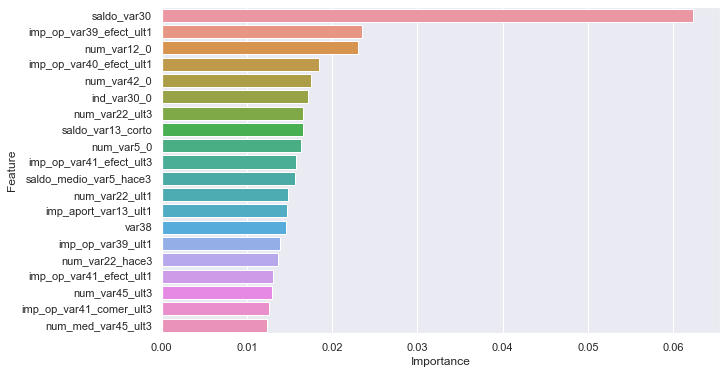

In [21]:
importance_df = plot_importances(xgb_low_var, list(low_var_low_corr.index), 20, return_df=True)

<AxesSubplot:xlabel='Importance', ylabel='Count'>

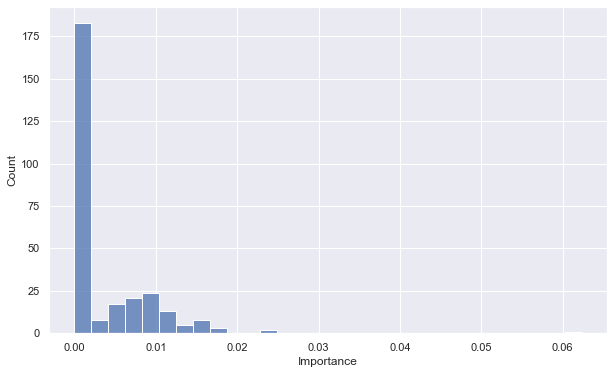

In [22]:
sns.histplot(importance_df.Importance)

A lot of the columns have 0 importance - remove these

In [23]:
low_var_corr_no_imp_cols = list(importance_df[importance_df.Importance == 0].Feature)

In [25]:
cols_to_remove = zero_var_cols + low_var_corr_no_imp_cols

In [27]:
def remove_low_var_cols(df, cols: str) -> pd.DataFrame:
    """Removes columns from data frame

    Args:
        df (_type_): train/test set
        cols (str): columns to remove

    Returns:
        pd.DataFrame: train/test without col
    """
    return df.drop(cols, axis=1)
pipeline["remove_low_var_cols"] = (remove_low_var_cols, {"cols": cols_to_remove})

**Target**

Positive class: 3.96%


C:\Users\joshu\.virtualenvs\kaggle-competitions-jWZu0GdS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


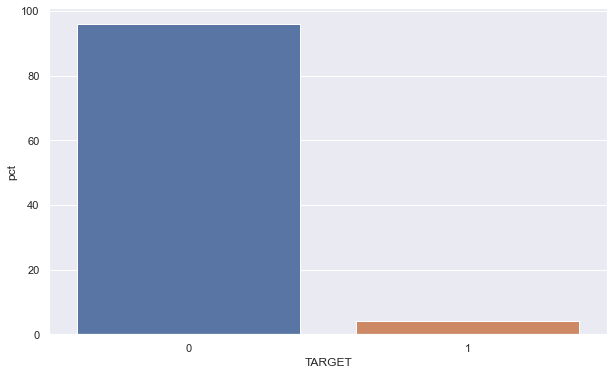

In [29]:
def plot_target_imbalance(df: pd.DataFrame) -> pd.DataFrame:
    df = np.round(df["TARGET"].value_counts() / df.shape[0] * 100, 2).reset_index()
    df.columns = ["TARGET", "pct"]
    sns.barplot(df["TARGET"], df["pct"])

plot_target_imbalance(train)
print(f'Positive class: {np.round(sum(train["TARGET"] == 1) / train.shape[0]*100, 2)}%')

### Preprocessing

In [31]:
train = preprocessing_pipeline(train, pipeline=pipeline)
test = preprocessing_pipeline(test, pipeline=pipeline)

In [32]:
X, y = extract_x_y(train, "TARGET")

### Dealing with class imbalance

### Basline models

**XGBoost**

In [41]:
%%capture
from xgboost import XGBClassifier

xgb = XGBClassifier()
cv_results_xgb = cross_val_score(xgb, X, y, cv=5, scoring="roc_auc")

In [91]:
cv_results_xgb.mean()

0.8208798870308283

**Catboost**

In [2]:
from catboost import CatBoostClassifier, Pool, cv

cb = CatBoostClassifier(task_type="GPU")
cv_results_cb = cross_val_score(cb, X, y, cv=5, scoring="roc_auc",)

In [92]:
cv_results_cb.mean()

0.8383017648146358

**Tune**

In [1]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': list(range(3, 10)),
    'n_estimators':[100, 200, 300]
}

#Instantiate GridSearchCV
grid_search = GridSearchCV(estimator = cb, param_grid = params, scoring ='roc_auc', cv = 5)
grid_search.fit(X, y)

In [83]:
grid_search.best_params_

{'max_depth': 6, 'n_estimators': 300}

In [84]:
best_model = grid_search.best_estimator_

In [3]:
%%capture

N_CV = 5

kfold = StratifiedKFold(n_splits=N_CV)

train_accuracy, test_accuracy = [], []

for train_idx, test_idx in kfold.split(X, y):
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]

    best_model.fit(X_train, y_train)
    y_hat_train = best_model.predict_proba(X_train)[:, 1]
    y_hat_test = best_model.predict_proba(X_test)[:, 1]

    train_accuracy.append(roc_auc_score(y_train, y_hat_train))
    test_accuracy.append(roc_auc_score(y_test, y_hat_test))

Mean train score 0.8762237580245602
Mean test score 0.8380787122523732


<AxesSubplot:xlabel='fold', ylabel='accuracy'>

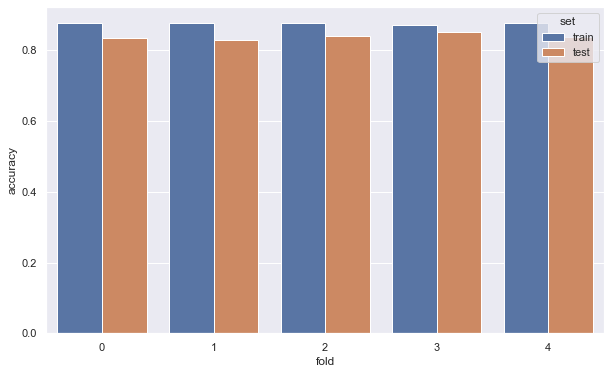

In [86]:
results_df = pd.DataFrame({
    "fold": list(range(N_CV)),
    "train": train_accuracy,
    "test": test_accuracy
})
results_df = pd.melt(results_df, id_vars="fold", var_name="set",value_name="accuracy")
print(f"Mean train score {np.mean(train_accuracy)}")
print(f"Mean test score {np.mean(test_accuracy)}")
sns.barplot(data=results_df, x="fold", y="accuracy", hue="set")

### Predict test set and submit

In [4]:
%%capture

best_model.fit(X, y)

In [88]:
# Load test set
test = pd.read_csv(FILE_PATH / "Data/test.csv")
test["TARGET"] = best_model.predict_proba(test)[:, 1]

In [89]:
test[["ID", "TARGET"]].to_csv(FILE_PATH / "Data/test_predictions.csv", index=False)